# Mostly Hand-Translated Simple Keras Model to C Language

````
BSD 2-Clause License

Copyright (c) 2019, Atsushi Yokoyama, Firmlogics (yokoyama@flogics.com)
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
````

# Give Random Seed to Get the Same Results Always

https://keras.io/getting-started/faq/

In [1]:
%env PYTHONHASHSEED=0

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(1)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(2)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(3)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

env: PYTHONHASHSEED=0


/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


# Define Constants

In [2]:
C_SRC_DIR = "c_project/src"

# Import Keras and Check Version

In [3]:
import keras

print(keras.__version__)

2.2.4


# Load Dataset

In [4]:
mnist = keras.datasets.mnist
(train_images_origin, train_labels), (test_images_origin, test_labels) = mnist.load_data()

print(train_images_origin.shape)

(60000, 28, 28)


# Examine a Training Sample

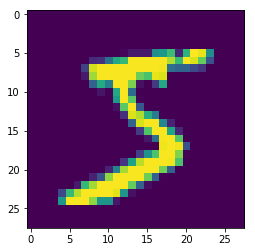

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.imshow(train_images_origin[0])
plt.grid(False)
plt.show()

# Normalize Range Sample Values

In [6]:
train_images = train_images_origin / 255.0
test_images = test_images_origin / 255.0

# Build the Model

In [7]:
from keras.layers import Flatten, Dense, Activation

model = keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128),
    Activation('relu'),
    Dense(10),
    Activation('softmax')
])

# Compile the Model

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model

In [9]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 54us/step - loss: 0.2639 - acc: 0.9239
Epoch 2/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.1137 - acc: 0.9663
Epoch 3/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0783 - acc: 0.9762
Epoch 4/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.0587 - acc: 0.9823
Epoch 5/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.0460 - acc: 0.9858


# Save the Model

In [10]:
model.save('mnist.h5')

# Or, Load the Model

In [11]:
# from keras.models import load_model
# model = load_model('mnist.h5')

# Evaluate accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 19us/step
Test accuracy: 0.9763


# Understand the Model Structure

In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


# Convert Input Vectors to C Style

In [14]:
N_SAMPLES = 20
WIDTH = 28
HEIGHT = 28

with open(C_SRC_DIR + "/test_images.c", "w") as f:
    f.write('#include "mnist.h"\n')
    f.write('#include "test_images.h"\n\n')
    f.write("const uint8_t TEST_IMAGES[{}][HEIGHT][WIDTH] = {{\n".format(N_SAMPLES))
            
    for i in range(N_SAMPLES):
        f.write("// Input #%d\n" % i)
        f.write("{\n")
        for y in range(HEIGHT):
            f.write("    {")
            for x in range(WIDTH):
                f.write(" %3d" % test_images_origin[i][y, x])
                if x < WIDTH - 1:
                    f.write(",")
                else:
                    f.write(" }")
            if y < HEIGHT - 1:
                f.write(",\n")
            else:
                f.write("\n")
        f.write("}")
        if i < N_SAMPLES - 1:
            f.write(",\n\n")
            
    f.write("};\n")

with open(C_SRC_DIR + "/test_images.h", "w") as f:
    f.write("""#ifndef __TEST_IMAGES_H__

const uint8_t TEST_IMAGES[{}][HEIGHT][WIDTH];

#define __TEST_IMAGES_H__
#endif""".format(N_SAMPLES))

with open(C_SRC_DIR + "/test_labels.h", "w") as f:
    f.write("""#ifndef __TEST_LABELS_H__

const int TEST_LABELS[{}];

#define __TEST_LABELS_H__
#endif""".format(N_SAMPLES))

with open(C_SRC_DIR + "/test_labels.c", "w") as f:
    f.write('#include "mnist.h"\n')
    f.write('#include "test_labels.h"\n\n')
    f.write("const int TEST_LABELS[{}] = {{\n   ".format(N_SAMPLES))
    for i in range(N_SAMPLES):
        f.write(" %1d" % test_labels[i])
        if i < N_SAMPLES - 1:
            f.write(",")
    f.write("\n};\n")

# Convert Trained Parameters to C Style

In [15]:
from keras.models import load_model

def write_one_array(model_filename, output_filename, var_name, np_array):
    len_array = np_array.shape[0]

    with open(output_filename, 'a') as f:
        f.write("float const {}[{:d}] = {{\n".format(var_name.upper(), len_array))
        for i in range(len_array - 1):
            f.write("    {:.6e},\n".format(np_array[i]))
        f.write("    {:.6e}\n".format(np_array[len_array - 1]))
        f.write("};\n\n")

def generate_params_file(model_filename, output_filename, layer_names):
    model = load_model(model_filename)
    ifdef_filename = "__" + output_filename.upper(). \
        replace('.', '_'). \
        replace('/', '_') + "__"

    with open(output_filename, 'w') as f:
        f.write("#ifndef {}\n\n".format(ifdef_filename))
        f.write("// {}\n\n".format(model_filename))
    
    for layer_name in layer_names:
        layer = model.get_layer(layer_name)
        weight = layer.get_weights()[0].flatten()
        bias = layer.get_weights()[1].flatten()
        write_one_array(model_filename, output_filename, layer_name + "_WEIGHT", weight)
        write_one_array(model_filename, output_filename, layer_name + "_BIAS", bias)
        
    with open(output_filename, 'a') as f:
        f.write("#define {}\n".format(ifdef_filename))
        f.write("#endif /* defined({}) */\n".format(ifdef_filename))

generate_params_file("mnist.h5", C_SRC_DIR +"/params.h", ["dense_1", "dense_2"])